# 🎂 Segmind Challenge : Prediction of Sales of each Store🎂

## TO DO:

> Predict store sales of a store using the given dataset.

## Data:
> Dataset Given

* The dataset consists of 4 CSV files:
* TRAIN.csv : (./dataset/TRAIN.csv)
* TEST.csv: (./dataset/TEST.csv)
* store.csv - additional information regarding the stores: (./dataset/store.csv)

## Evaluate:
* Time-series prediction problem.
* Sales has direct correlation to OPEN or not

## Features:
> From Test data

* Store: Store number
* DayOfWeek: Day (out of 7) per week
* Date: DD-MM-YYYY format
* Open: 1 for open, 0 for close
* Promo: 0 or 1 
* StateHoliday: 0, a, b, c (0 or store type)
* SchoolHoliday: 0 or 1

## 🤳Imports

In [1]:
# Essentials
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from dateutil.parser import parse
from math import ceil
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import ElasticNet, Lasso, SGDRegressor, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostRegressor,ExtraTreesRegressor,GradientBoostingRegressor,RandomForestRegressor
import xgboost
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pprint import pprint

import pickle

## 💚Inputs

In [2]:
# Store data
def import_store():
    storedf = pd.read_csv('./dataset/store.csv')
    return storedf
# Sales data
def import_data(x):
    df = pd.read_csv('./dataset/'+x+'.csv')
    return df

## 💌Total preprocessing

In [3]:
# Store attributes
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
months_with_store = ['Store','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
num_attribs = ["CompetitionDistance",
               "CompetitionOpenSinceMonth",
               "CompetitionOpenSinceYear",
               "Promo2SinceWeek",
               "Promo2SinceYear"]
# scale_attribs = ["CompetitionDistance"]
obj_attribs = ["StoreType", "Assortment"]

In [4]:
# Store Pipelines

# cd_pipeline_median = Pipeline([
#     ("imputer", SimpleImputer(strategy='median')),
#     ("stdscale", StandardScaler())
# ])

# cd_pipeline_mean = Pipeline([
#     ("imputer", SimpleImputer(strategy='mean')),
#     ("stdscale", StandardScaler())
# ])

# cd_pipeline_mode = Pipeline([
#     ("imputer", SimpleImputer(strategy='most_frequent')),
#     ("stdscale", StandardScaler())
# ])

full_pipeline_median = ColumnTransformer([
    ("num", SimpleImputer(strategy='median'), num_attribs),
    #("stdscale", StandardScaler(), num_attribs),
    ("cat", OrdinalEncoder(), obj_attribs)
])

full_pipeline_mean = ColumnTransformer([
    ("num", SimpleImputer(strategy='mean'), num_attribs),
    ("cat", OrdinalEncoder(), obj_attribs)
])

full_pipeline_mode = ColumnTransformer([
    ("num", SimpleImputer(strategy='most_frequent'), num_attribs),
    ("cat", OrdinalEncoder(), obj_attribs)
])

In [5]:
# Sore Preprocessing

def divide_promointerval():
    '''
    1. Fillna with '0' in PROMOINTERVAL
    2. Dividing PromoInterval into months and applying custom one hot encoding
    4. Drop PROMOINTERVAL
    ----------
    PARAMETERS
    ----------
    NA
    -------
    RETURNS
    -------    
    test: DF after divinding the Promointerval into months
    '''
    store['PromoInterval'].fillna(value='0', inplace=True)
    test = pd.DataFrame(data=store.Store, columns=months_with_store)
    for month in months:
        test[month] = np.where(store["PromoInterval"].str.contains(month), 1, 0)
    if 'PromoInterval' in store.columns:    
        store.drop('PromoInterval', inplace=True, axis=1)    
    return test

def drop_store_columns():
    '''
    Dropping columns after preprocessing.
    '''
    for attri in num_attribs:
        if attri in store.columns:
            store.drop(attri, inplace=True, axis=1)
    for attri in obj_attribs:
        if attri in store.columns:
            store.drop(attri, inplace=True, axis=1)         

In [6]:
# Store transformation
store = import_store()
store_tranformed = full_pipeline_median.fit_transform(store)
drop_store_columns()
store_prepared = pd.DataFrame(data=store_tranformed, columns=(num_attribs+obj_attribs), index=store.index)
store = store.join(store_prepared)
month_df = divide_promointerval()
store_df = pd.merge(left=store, right=month_df, on='Store')

In [7]:
# Data Preprocessing
def week_of_month(tgtdate):
    date = parse(tgtdate)
    first_day = date.replace(day=1)

    day_of_month = date.day

    if(first_day.weekday() == 6):
        adjusted_dom = (1 + first_day.weekday()) / 7
    else:
        adjusted_dom = day_of_month + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

def change_tf(true_false):
    if true_false == True:
        return 1
    else:
        return 0

def date_preproccesing():
    train_df['year'] = pd.DatetimeIndex(train_df['Date']).year
    train_df['month'] = pd.DatetimeIndex(train_df['Date']).month
    train_df['quarter'] = pd.DatetimeIndex(train_df['Date']).quarter
    train_df['dayofyear'] = pd.DatetimeIndex(train_df['Date']).dayofyear
    train_df['weekofyear'] = pd.DatetimeIndex(train_df['Date']).weekofyear
    train_df['week'] = pd.DatetimeIndex(train_df['Date']).week
    train_df['is_month_start'] = pd.DatetimeIndex(train_df['Date']).is_month_start
    train_df['is_month_end'] = pd.DatetimeIndex(train_df['Date']).is_month_end
    train_df['is_year_end'] = pd.DatetimeIndex(train_df['Date']).is_year_end
    train_df['is_year_start'] = pd.DatetimeIndex(train_df['Date']).is_year_start
    train_df["StateHoliday"] = train_df["StateHoliday"].apply(lambda x: str(x))
    train_df["WeekOfMonth"] = train_df["Date"].apply(week_of_month)
    train_df["is_month_start"] = train_df["is_month_start"].apply(lambda x: change_tf(x))
    train_df["is_month_end"] = train_df["is_month_end"].apply(lambda x: change_tf(x))
    train_df["is_year_end"] = train_df["is_year_end"].apply(lambda x: change_tf(x))
    train_df["is_year_start"] = train_df["is_year_start"].apply(lambda x: change_tf(x))

def cat_transformation(x):
    if 'train' in x:
        train_df['StateHolidayCat'] = labelencoder.fit_transform(train_df['StateHoliday'])
    else:
        train_df['StateHolidayCat'] = labelencoder.transform(train_df['StateHoliday'])

def drop_data_columns():
    if 'Date' in train_df.columns:
        train_df.drop('Date', inplace=True, axis=1)
    if 'StateHoliday' in train_df.columns:
        train_df.drop('StateHoliday', axis=1, inplace=True)
    if 'Customers' in train_df.columns:
        train_df.drop('Customers', axis=1, inplace=True)

In [8]:
labelencoder = LabelEncoder()

In [44]:
# Data transformation
# labelencoder = LabelEncoder()
train_or_test = 'test' #'test' 'train'
train_df = import_data(train_or_test)
date_preproccesing()
if 'train' in train_or_test:
    labelencoder.fit(train_df['StateHoliday'])
    train_df['StateHolidayCat'] = labelencoder.transform(train_df['StateHoliday'])
#     labelencoder.fit_transform(train_df['StateHoliday'])
else:
    train_df['StateHolidayCat'] = labelencoder.transform(train_df['StateHoliday'])
# train_df['StateHolidayCat'] = labelencoder.transform(train_df['StateHoliday'])
# cat_transformation(train_or_test)
drop_data_columns()

<ipython-input-7-1c317fd3e691>:26: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  train_df['weekofyear'] = pd.DatetimeIndex(train_df['Date']).weekofyear
<ipython-input-7-1c317fd3e691>:27: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  train_df['week'] = pd.DatetimeIndex(train_df['Date']).week


In [45]:
# Final_df
# final_df = pd.merge(left=train_df, right=store_df, on='Store')
final_df = pd.merge(train_df,store_df, how='left', left_on='Store', right_on='Store')
#final_df.drop('Store', axis=1, inplace=True)

In [46]:
final_df.columns

Index(['Store', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'year', 'month',
       'quarter', 'dayofyear', 'weekofyear', 'week', 'is_month_start',
       'is_month_end', 'is_year_end', 'is_year_start', 'WeekOfMonth',
       'StateHolidayCat', 'Promo2', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
       'Promo2SinceWeek', 'Promo2SinceYear', 'StoreType', 'Assortment', 'Jan',
       'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov',
       'Dec'],
      dtype='object')

## 🎁Modelling

In [30]:
# Splitting the data
X = final_df.drop('Sales', axis=1)
y = final_df['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [31]:
# Working on MLP Regressor

MLP = MLPRegressor(verbose=True, 
                   learning_rate_init=0.001, 
                   early_stopping=True, 
                   random_state=42, 
                   validation_fraction=0.1)
MLP.fit(X_train, y_train)

Iteration 1, loss = 7782669.93946465
Validation score: 0.028111
Iteration 2, loss = 7191042.40755035
Validation score: 0.108591
Iteration 3, loss = 6386798.01786398
Validation score: 0.236618
Iteration 4, loss = 5476233.88072951
Validation score: 0.337995
Iteration 5, loss = 4896380.50541199
Validation score: 0.391944
Iteration 6, loss = 4580225.05331142
Validation score: 0.413386
Iteration 7, loss = 4387014.04585517
Validation score: 0.443362
Iteration 8, loss = 4221242.55570221
Validation score: 0.464903
Iteration 9, loss = 4077993.02569499
Validation score: 0.475621
Iteration 10, loss = 3967458.56812556
Validation score: 0.494011
Iteration 11, loss = 3874827.49602028
Validation score: 0.499336
Iteration 12, loss = 3792866.51296341
Validation score: 0.511468
Iteration 13, loss = 3729960.43873051
Validation score: 0.493563
Iteration 14, loss = 3675117.42437652
Validation score: 0.491303
Iteration 15, loss = 3626333.02214313
Validation score: 0.538023
Iteration 16, loss = 3579587.43301

MLPRegressor(early_stopping=True, random_state=42, verbose=True)

In [35]:
mean_absolute_error(y_test, MLP.predict(X_test))

1740.4311686399053

In [36]:
MLP.score(X_test, y_test)

0.5844549970625768

In [34]:
# Try 2
MLP = MLPRegressor(verbose=True,
                   shuffle=True,
                   early_stopping=True, 
                   random_state=42, 
                   validation_fraction=0.1)
MLP.fit(X_train, y_train)

Iteration 1, loss = 7782669.93946465
Validation score: 0.028111
Iteration 2, loss = 7191042.40755035
Validation score: 0.108591
Iteration 3, loss = 6386798.01786398
Validation score: 0.236618
Iteration 4, loss = 5476233.88072951
Validation score: 0.337995
Iteration 5, loss = 4896380.50541199
Validation score: 0.391944
Iteration 6, loss = 4580225.05331142
Validation score: 0.413386
Iteration 7, loss = 4387014.04585517
Validation score: 0.443362
Iteration 8, loss = 4221242.55570221
Validation score: 0.464903
Iteration 9, loss = 4077993.02569499
Validation score: 0.475621
Iteration 10, loss = 3967458.56812556
Validation score: 0.494011
Iteration 11, loss = 3874827.49602028
Validation score: 0.499336
Iteration 12, loss = 3792866.51296341
Validation score: 0.511468
Iteration 13, loss = 3729960.43873051
Validation score: 0.493563
Iteration 14, loss = 3675117.42437652
Validation score: 0.491303
Iteration 15, loss = 3626333.02214313
Validation score: 0.538023
Iteration 16, loss = 3579587.43301

MLPRegressor(early_stopping=True, random_state=42, verbose=True)

In [37]:
# Giving up on MLP regressor, Moving on to Gradientboosting

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=5000, verbose=2)
gbrt.fit(X_train, y_train)



      Iter       Train Loss   Remaining Time 
         1    13778226.9931           58.45m
         2    12511518.8246           56.44m
         3    11485485.2082           57.44m
         4    10654397.9788           56.63m
         5     9981217.3231           56.15m
         6     9435940.9919           55.57m
         7     8994267.1637           55.34m
         8     8636511.3628           55.82m
         9     8344104.3713           55.63m
        10     8101515.4458           55.99m
        11     7898920.4475           55.70m
        12     7731657.5270           55.99m
        13     7590933.6759           56.34m
        14     7473039.9726           56.11m
        15     7374355.6258           56.21m
        16     7291098.1201           56.47m
        17     7219090.2364           56.73m
        18     7131081.0297           56.92m
        19     7059793.5723           57.07m
        20     7002050.7318           57.11m
        21     6951143.2841           57.15m
        2

       183     5391881.1820           57.03m
       184     5388789.7061           57.02m
       185     5386756.2153           57.00m
       186     5384598.3089           56.98m
       187     5383063.6374           56.96m
       188     5375365.4802           56.96m
       189     5374347.9641           56.94m
       190     5365588.5619           56.92m
       191     5343794.3908           56.92m
       192     5340660.7434           56.89m
       193     5339702.9729           56.87m
       194     5329200.7180           56.84m
       195     5324414.4866           56.83m
       196     5321758.8363           56.83m
       197     5319593.5493           56.82m
       198     5317368.1175           56.81m
       199     5315872.1438           56.80m
       200     5309378.5008           56.78m
       201     5305576.8070           56.75m
       202     5303437.9017           56.75m
       203     5296343.7271           56.73m
       204     5293506.3043           56.71m
       205

       366     4739765.4712           54.77m
       367     4737461.7310           54.74m
       368     4728744.3738           54.71m
       369     4725453.4595           54.69m
       370     4724062.1022           54.66m
       371     4721336.0658           54.63m
       372     4718500.1728           54.60m
       373     4717189.4634           54.57m
       374     4715049.4467           54.54m
       375     4712165.9192           54.51m
       376     4710639.7035           54.48m
       377     4706903.7713           54.45m
       378     4706057.2758           54.42m
       379     4703438.3305           54.39m
       380     4700482.4850           54.37m
       381     4698676.2568           54.34m
       382     4698125.0363           54.31m
       383     4696351.9418           54.28m
       384     4686541.5522           54.25m
       385     4684615.2355           54.23m
       386     4684145.7613           54.20m
       387     4682846.9440           54.17m
       388

       549     4342036.6859           50.53m
       550     4341385.3669           50.51m
       551     4338113.5820           50.48m
       552     4335506.0928           50.47m
       553     4334798.3938           50.45m
       554     4332720.6270           50.43m
       555     4331283.7925           50.41m
       556     4329658.5382           50.39m
       557     4321336.9820           50.37m
       558     4320622.2888           50.35m
       559     4320372.3437           50.33m
       560     4319169.8541           50.31m
       561     4317748.5797           50.29m
       562     4316117.3313           50.27m
       563     4313539.2097           50.25m
       564     4307840.3983           50.23m
       565     4306748.3098           50.22m
       566     4305194.0016           50.20m
       567     4304070.6946           50.18m
       568     4303047.6752           50.16m
       569     4301023.7531           50.14m
       570     4299185.1983           50.12m
       571

       732     4020560.0960           47.42m
       733     4019847.3411           47.40m
       734     4018479.9782           47.39m
       735     4018371.5288           47.37m
       736     4017752.1845           47.35m
       737     4016655.2277           47.34m
       738     4015445.4398           47.32m
       739     4014542.0723           47.31m
       740     4012972.6668           47.29m
       741     4011441.9047           47.28m
       742     4009999.0891           47.26m
       743     4008047.7031           47.25m
       744     4003678.4184           47.23m
       745     4002582.2744           47.22m
       746     4001336.1471           47.20m
       747     3998383.5001           47.19m
       748     3998256.8641           47.17m
       749     3997683.4916           47.16m
       750     3996722.6253           47.14m
       751     3996209.8809           47.13m
       752     3994768.1438           47.11m
       753     3993560.7016           47.10m
       754

       915     3775070.0399           44.82m
       916     3773062.4742           44.80m
       917     3771768.4300           44.79m
       918     3770964.3815           44.78m
       919     3770099.1352           44.76m
       920     3769835.9859           44.75m
       921     3769760.9795           44.73m
       922     3769227.1425           44.72m
       923     3769050.2753           44.71m
       924     3768139.3742           44.70m
       925     3767900.0388           44.68m
       926     3766817.1892           44.67m
       927     3765307.2321           44.65m
       928     3762922.2186           44.64m
       929     3761314.6055           44.63m
       930     3758427.1376           44.62m
       931     3753186.4237           44.60m
       932     3751926.7036           44.59m
       933     3751359.0851           44.58m
       934     3750846.8655           44.57m
       935     3750363.8706           44.55m
       936     3750266.8074           44.54m
       937

      1098     3583258.1113           42.45m
      1099     3579729.4409           42.44m
      1100     3579083.3484           42.42m
      1101     3578959.5837           42.41m
      1102     3578397.8495           42.40m
      1103     3577597.8142           42.39m
      1104     3577442.6510           42.38m
      1105     3576598.9920           42.36m
      1106     3576117.8818           42.35m
      1107     3575356.1263           42.34m
      1108     3575212.4256           42.32m
      1109     3573676.4685           42.31m
      1110     3573622.3975           42.30m
      1111     3573119.4161           42.28m
      1112     3572438.9799           42.27m
      1113     3572049.6157           42.26m
      1114     3571595.1510           42.25m
      1115     3570820.3666           42.23m
      1116     3569868.5321           42.22m
      1117     3569315.8542           42.21m
      1118     3568642.4725           42.20m
      1119     3567864.2339           42.18m
      1120

      1281     3426441.8732           40.21m
      1282     3425989.3719           40.20m
      1283     3425429.4754           40.18m
      1284     3424248.6420           40.17m
      1285     3422521.4424           40.16m
      1286     3422459.4443           40.15m
      1287     3421492.3902           40.13m
      1288     3420696.4691           40.12m
      1289     3419262.5623           40.11m
      1290     3417807.7539           40.10m
      1291     3416540.5463           40.09m
      1292     3415304.8360           40.07m
      1293     3415163.0675           40.06m
      1294     3415106.2074           40.05m
      1295     3414715.7148           40.04m
      1296     3414315.4607           40.02m
      1297     3413711.2281           40.01m
      1298     3413020.8117           40.00m
      1299     3412446.9449           39.99m
      1300     3411000.0393           39.98m
      1301     3410658.4372           39.97m
      1302     3409427.4959           39.95m
      1303

      1464     3269541.2544           38.05m
      1465     3269007.7115           38.03m
      1466     3268348.7422           38.02m
      1467     3267926.9190           38.01m
      1468     3267317.8135           38.00m
      1469     3266828.4072           37.99m
      1470     3259851.4375           37.98m
      1471     3259258.1312           37.96m
      1472     3258859.0649           37.95m
      1473     3257405.1682           37.94m
      1474     3256840.6785           37.93m
      1475     3255680.4526           37.92m
      1476     3251673.3957           37.91m
      1477     3246004.2843           37.89m
      1478     3245596.8198           37.88m
      1479     3245120.8748           37.87m
      1480     3244665.1009           37.86m
      1481     3244221.1752           37.85m
      1482     3243030.7864           37.84m
      1483     3242013.9926           37.82m
      1484     3240966.3633           37.81m
      1485     3240582.1138           37.80m
      1486

      1647     3114629.2524           35.97m
      1648     3113673.9419           35.96m
      1649     3113404.0531           35.95m
      1650     3112622.2326           35.94m
      1651     3112132.4982           35.93m
      1652     3109230.6651           35.92m
      1653     3108887.4772           35.91m
      1654     3108420.6217           35.90m
      1655     3108030.9960           35.88m
      1656     3107363.1667           35.87m
      1657     3107001.4466           35.86m
      1658     3106589.4617           35.85m
      1659     3106248.5404           35.84m
      1660     3105631.9883           35.83m
      1661     3103891.6228           35.82m
      1662     3103497.9403           35.80m
      1663     3103018.4353           35.79m
      1664     3102591.6373           35.78m
      1665     3101767.8295           35.77m
      1666     3101701.1882           35.76m
      1667     3101426.3661           35.75m
      1668     3101023.6675           35.74m
      1669

      1830     3008313.0240           33.91m
      1831     3007927.7331           33.90m
      1832     3007559.9553           33.89m
      1833     3006843.4090           33.88m
      1834     3006472.6090           33.87m
      1835     3006363.0320           33.85m
      1836     3005505.8810           33.84m
      1837     3005165.6630           33.83m
      1838     3003659.4972           33.82m
      1839     3003357.1833           33.81m
      1840     3003328.5128           33.80m
      1841     3003005.4729           33.79m
      1842     3002727.1971           33.78m
      1843     3002405.4328           33.77m
      1844     3001978.4076           33.76m
      1845     3001952.6044           33.74m
      1846     3001818.1402           33.73m
      1847     3001769.7903           33.72m
      1848     3001533.2345           33.71m
      1849     3000764.3607           33.70m
      1850     3000451.3119           33.69m
      1851     2999825.4391           33.68m
      1852

      2013     2911275.5355           31.90m
      2014     2911120.9983           31.89m
      2015     2910810.3659           31.88m
      2016     2910581.8921           31.87m
      2017     2910469.1908           31.86m
      2018     2910301.7298           31.84m
      2019     2909897.7055           31.83m
      2020     2909742.8607           31.82m
      2021     2908885.1091           31.81m
      2022     2908575.2329           31.80m
      2023     2908303.2423           31.79m
      2024     2908199.5223           31.78m
      2025     2907504.0569           31.77m
      2026     2907326.8277           31.76m
      2027     2907163.4739           31.74m
      2028     2906900.2433           31.73m
      2029     2906163.5502           31.72m
      2030     2905832.3244           31.71m
      2031     2905526.1395           31.70m
      2032     2905061.8235           31.69m
      2033     2903674.4908           31.68m
      2034     2903299.1753           31.67m
      2035

      2196     2807609.3315           29.98m
      2197     2807327.2500           29.97m
      2198     2806794.6646           29.96m
      2199     2806604.2983           29.95m
      2200     2806454.6630           29.94m
      2201     2806403.2458           29.93m
      2202     2806163.5273           29.92m
      2203     2805929.2478           29.91m
      2204     2805850.8907           29.90m
      2205     2805691.7881           29.89m
      2206     2805546.8996           29.88m
      2207     2805048.7252           29.87m
      2208     2805023.6909           29.85m
      2209     2804918.5949           29.84m
      2210     2804388.2187           29.83m
      2211     2804106.2324           29.82m
      2212     2803862.0708           29.81m
      2213     2802212.7207           29.80m
      2214     2799293.6929           29.79m
      2215     2798603.3009           29.78m
      2216     2798451.1003           29.77m
      2217     2798410.8665           29.76m
      2218

      2379     2713574.8259           28.07m
      2380     2713276.0997           28.06m
      2381     2713056.9700           28.05m
      2382     2712873.0263           28.04m
      2383     2712638.0966           28.03m
      2384     2712395.6233           28.02m
      2385     2712302.3776           28.01m
      2386     2712204.6855           28.00m
      2387     2712058.4384           27.99m
      2388     2711626.1484           27.98m
      2389     2708782.6973           27.97m
      2390     2705030.2149           27.96m
      2391     2704537.1954           27.95m
      2392     2702419.9143           27.94m
      2393     2702048.9035           27.93m
      2394     2701877.1851           27.92m
      2395     2701075.2705           27.91m
      2396     2699977.1943           27.90m
      2397     2699652.7930           27.89m
      2398     2699493.6104           27.88m
      2399     2697758.7162           27.87m
      2400     2697309.8329           27.86m
      2401

      2562     2618871.4644           26.47m
      2563     2618757.1811           26.46m
      2564     2618195.9138           26.45m
      2565     2617413.8602           26.44m
      2566     2616683.9211           26.43m
      2567     2616590.2251           26.42m
      2568     2616464.0127           26.42m
      2569     2616261.6504           26.41m
      2570     2616075.0485           26.40m
      2571     2615894.9317           26.39m
      2572     2615660.5214           26.38m
      2573     2615541.6293           26.37m
      2574     2615375.1145           26.36m
      2575     2614724.0611           26.35m
      2576     2614255.6518           26.34m
      2577     2614222.0643           26.33m
      2578     2614045.6256           26.33m
      2579     2613393.7725           26.32m
      2580     2613158.2357           26.31m
      2581     2612823.2602           26.30m
      2582     2612553.1407           26.29m
      2583     2612236.1794           26.28m
      2584

      2745     2552576.6993           24.88m
      2746     2552461.6807           24.87m
      2747     2552301.3995           24.86m
      2748     2551814.9110           24.85m
      2749     2551710.9801           24.84m
      2750     2551599.7686           24.83m
      2751     2551285.2924           24.82m
      2752     2550665.4732           24.81m
      2753     2550244.6187           24.80m
      2754     2549808.6309           24.79m
      2755     2549755.5902           24.77m
      2756     2549376.1930           24.76m
      2757     2549193.0359           24.75m
      2758     2549004.7990           24.74m
      2759     2548774.6505           24.73m
      2760     2548566.9585           24.72m
      2761     2548168.8419           24.71m
      2762     2547655.1824           24.70m
      2763     2547311.0265           24.69m
      2764     2546981.5226           24.68m
      2765     2546448.7638           24.67m
      2766     2546303.4912           24.65m
      2767

      2928     2492023.6952           23.74m
      2929     2491831.9381           23.73m
      2930     2491588.0438           23.72m
      2931     2491282.1758           23.72m
      2932     2490696.1459           23.71m
      2933     2490514.8406           23.70m
      2934     2489775.6249           23.70m
      2935     2489383.3573           23.69m
      2936     2489290.2099           23.69m
      2937     2488849.6791           23.68m
      2938     2488250.2032           23.67m
      2939     2487909.8579           23.67m
      2940     2487291.9040           23.66m
      2941     2486772.2490           23.66m
      2942     2486634.7694           23.65m
      2943     2486496.0105           23.64m
      2944     2486069.4455           23.64m
      2945     2485837.8275           23.63m
      2946     2485555.7261           23.63m
      2947     2485274.7259           23.62m
      2948     2484937.9249           23.61m
      2949     2484758.3239           23.61m
      2950

      3111     2437618.6472           22.45m
      3112     2437106.5298           22.45m
      3113     2434947.3925           22.44m
      3114     2434573.7970           22.43m
      3115     2434112.5763           22.42m
      3116     2433247.4840           22.41m
      3117     2432723.5298           22.41m
      3118     2432590.4898           22.40m
      3119     2432169.3955           22.39m
      3120     2430924.0069           22.38m
      3121     2430230.4571           22.38m
      3122     2428941.7733           22.37m
      3123     2428671.5866           22.36m
      3124     2428410.6386           22.35m
      3125     2427908.9187           22.35m
      3126     2427710.9926           22.34m
      3127     2426009.6036           22.33m
      3128     2425658.6023           22.32m
      3129     2425494.0361           22.31m
      3130     2425366.4778           22.31m
      3131     2425123.1658           22.30m
      3132     2425020.3248           22.29m
      3133

      3294     2377263.3035           20.82m
      3295     2376955.8637           20.81m
      3296     2376929.7310           20.80m
      3297     2376892.5587           20.79m
      3298     2376652.3702           20.78m
      3299     2376492.9259           20.77m
      3300     2376416.5534           20.76m
      3301     2376323.9911           20.75m
      3302     2375988.3790           20.74m
      3303     2375800.1334           20.74m
      3304     2375709.0853           20.73m
      3305     2375553.8596           20.72m
      3306     2375424.8767           20.71m
      3307     2375193.8138           20.70m
      3308     2374726.7992           20.69m
      3309     2374711.7409           20.68m
      3310     2374603.4000           20.67m
      3311     2374402.1260           20.66m
      3312     2374355.9541           20.65m
      3313     2374269.8986           20.64m
      3314     2374136.4102           20.63m
      3315     2374035.8919           20.62m
      3316

      3477     2331276.5785           19.02m
      3478     2330807.6213           19.01m
      3479     2330533.2412           18.99m
      3480     2330370.4265           18.98m
      3481     2329584.7248           18.97m
      3482     2329272.2632           18.96m
      3483     2328474.4629           18.95m
      3484     2328125.4639           18.94m
      3485     2327895.2970           18.93m
      3486     2327735.8830           18.92m
      3487     2327611.3011           18.91m
      3488     2327537.0297           18.90m
      3489     2327205.0044           18.89m
      3490     2326977.1260           18.88m
      3491     2326916.6104           18.87m
      3492     2326550.3869           18.86m
      3493     2326332.9155           18.85m
      3494     2326230.1834           18.84m
      3495     2326053.8171           18.83m
      3496     2325866.2228           18.82m
      3497     2325683.3863           18.81m
      3498     2325515.0913           18.80m
      3499

      3660     2278483.6446           17.05m
      3661     2277995.2639           17.04m
      3662     2277867.4750           17.03m
      3663     2277797.6763           17.02m
      3664     2277669.2787           17.01m
      3665     2276888.3451           17.00m
      3666     2276771.0802           16.99m
      3667     2276429.7929           16.97m
      3668     2276003.9141           16.96m
      3669     2275859.8938           16.95m
      3670     2275592.9527           16.94m
      3671     2275146.3840           16.93m
      3672     2274875.7940           16.92m
      3673     2274074.8275           16.91m
      3674     2273684.2180           16.90m
      3675     2273220.9696           16.89m
      3676     2273196.7794           16.88m
      3677     2273172.4855           16.87m
      3678     2272741.3882           16.85m
      3679     2272720.9778           16.84m
      3680     2272402.6933           16.83m
      3681     2272230.3302           16.82m
      3682

      3843     2231233.5057           15.01m
      3844     2230733.9412           15.00m
      3845     2230360.8344           14.99m
      3846     2230128.2289           14.98m
      3847     2229913.8666           14.96m
      3848     2229658.1791           14.95m
      3849     2229248.4530           14.94m
      3850     2229190.2919           14.93m
      3851     2229148.4568           14.91m
      3852     2229094.2733           14.90m
      3853     2228953.4662           14.89m
      3854     2228515.1984           14.88m
      3855     2228284.3156           14.86m
      3856     2228177.4183           14.85m
      3857     2228039.6518           14.84m
      3858     2227783.1072           14.83m
      3859     2227442.5983           14.82m
      3860     2227176.8916           14.81m
      3861     2226850.8417           14.79m
      3862     2226746.3771           14.78m
      3863     2226634.9852           14.77m
      3864     2226512.4995           14.76m
      3865

      4026     2196870.8393           12.86m
      4027     2196721.0627           12.85m
      4028     2196547.1590           12.83m
      4029     2196503.2087           12.82m
      4030     2196345.7894           12.81m
      4031     2196258.5067           12.80m
      4032     2195893.1841           12.79m
      4033     2195795.0300           12.77m
      4034     2195776.7814           12.76m
      4035     2195711.5923           12.75m
      4036     2195628.1877           12.74m
      4037     2195560.4068           12.72m
      4038     2195334.1220           12.71m
      4039     2195265.8276           12.70m
      4040     2195203.6974           12.69m
      4041     2195002.5035           12.68m
      4042     2194893.1465           12.66m
      4043     2194832.1046           12.65m
      4044     2194709.1099           12.64m
      4045     2194491.3487           12.63m
      4046     2194430.3380           12.62m
      4047     2194377.7801           12.60m
      4048

      4209     2175973.4774           10.59m
      4210     2175790.0869           10.58m
      4211     2175691.5197           10.57m
      4212     2175541.7627           10.56m
      4213     2175428.4902           10.54m
      4214     2175215.9227           10.53m
      4215     2174605.7739           10.52m
      4216     2174590.2346           10.51m
      4217     2174225.0682           10.49m
      4218     2174112.2324           10.48m
      4219     2173941.8960           10.47m
      4220     2173792.5798           10.46m
      4221     2173638.5113           10.45m
      4222     2173493.3140           10.43m
      4223     2173416.3467           10.42m
      4224     2173342.6519           10.41m
      4225     2173183.9612           10.40m
      4226     2173045.1950           10.38m
      4227     2172732.0911           10.37m
      4228     2172210.2540           10.36m
      4229     2171852.4435           10.35m
      4230     2171459.0321           10.33m
      4231

      4392     2144351.8797            8.28m
      4393     2144269.0529            8.26m
      4394     2144205.8474            8.25m
      4395     2144115.8679            8.24m
      4396     2144005.3620            8.23m
      4397     2143821.6955            8.21m
      4398     2143640.4716            8.20m
      4399     2143139.9103            8.19m
      4400     2142994.2846            8.17m
      4401     2142760.2068            8.16m
      4402     2142398.0285            8.15m
      4403     2142270.8553            8.13m
      4404     2142039.1770            8.12m
      4405     2141789.8980            8.11m
      4406     2141630.1106            8.10m
      4407     2141091.5189            8.08m
      4408     2140723.2827            8.07m
      4409     2140298.3816            8.06m
      4410     2140058.6414            8.04m
      4411     2139964.7497            8.03m
      4412     2139877.1642            8.02m
      4413     2139748.1530            8.00m
      4414

      4575     2114361.0088            5.87m
      4576     2114303.6794            5.86m
      4577     2114194.2785            5.84m
      4578     2114163.7932            5.83m
      4579     2114083.5864            5.82m
      4580     2114017.6300            5.80m
      4581     2113507.3789            5.79m
      4582     2113408.1566            5.78m
      4583     2113313.6904            5.76m
      4584     2113217.5735            5.75m
      4585     2112933.0398            5.74m
      4586     2112855.2225            5.72m
      4587     2112749.2766            5.71m
      4588     2112607.4888            5.70m
      4589     2112488.2433            5.68m
      4590     2112264.5472            5.67m
      4591     2112208.1635            5.66m
      4592     2112075.2299            5.64m
      4593     2111893.2725            5.63m
      4594     2111483.2255            5.62m
      4595     2111371.8554            5.60m
      4596     2111182.8857            5.59m
      4597

      4758     2091898.4165            3.35m
      4759     2091829.5674            3.33m
      4760     2091723.5045            3.32m
      4761     2091657.4271            3.30m
      4762     2091567.9443            3.29m
      4763     2091312.0875            3.28m
      4764     2091065.1384            3.26m
      4765     2090949.8567            3.25m
      4766     2090895.4815            3.23m
      4767     2090695.1615            3.22m
      4768     2090608.2853            3.21m
      4769     2090558.2355            3.19m
      4770     2090481.0965            3.18m
      4771     2090378.9151            3.17m
      4772     2090308.7188            3.15m
      4773     2090212.1114            3.14m
      4774     2090164.9891            3.12m
      4775     2090024.4680            3.11m
      4776     2089897.2741            3.10m
      4777     2089862.3265            3.08m
      4778     2089776.3045            3.07m
      4779     2089681.8928            3.05m
      4780

      4941     2070597.2282           48.55s
      4942     2070422.4188           47.73s
      4943     2070317.7479           46.90s
      4944     2070151.0145           46.08s
      4945     2070024.7200           45.25s
      4946     2069927.8331           44.43s
      4947     2069848.0366           43.60s
      4948     2069787.7520           42.78s
      4949     2069730.1914           41.95s
      4950     2069633.8019           41.13s
      4951     2069492.0454           40.31s
      4952     2069285.1369           39.48s
      4953     2069201.9877           38.66s
      4954     2069135.7160           37.83s
      4955     2069064.2841           37.01s
      4956     2068927.8842           36.19s
      4957     2068890.2791           35.36s
      4958     2068825.9244           34.54s
      4959     2068745.7731           33.71s
      4960     2068547.3411           32.89s
      4961     2068456.8784           32.07s
      4962     2068319.4323           31.24s
      4963

GradientBoostingRegressor(max_depth=2, n_estimators=5000, verbose=2)

In [38]:
y_pred = gbrt.predict(X_test)
errors = [mean_squared_error(y_test, y_pred)
          for y_pred in gbrt.staged_predict(X_test)]
bst_n_estimators = np.argmin(errors)+1
print(bst_n_estimators)

5000


In [39]:
mean_squared_error(y_test, y_pred)

2085904.73434837

In [40]:
gbrt.score(X_test,y_test)

0.8645012140119538

In [41]:
pickle.dump(gbrt, open("GradientBoostingRegressor.pkl","wb"))

In [42]:
gbrt.feature_importances_

array([1.37339492e-01, 2.74740139e-02, 5.37475038e-01, 8.92230869e-02,
       4.48413661e-04, 5.31231711e-04, 1.67918400e-04, 2.75586813e-05,
       2.35577934e-02, 6.21273270e-03, 6.70861470e-03, 1.74961991e-04,
       3.85940184e-03, 5.30714799e-04, 2.58437250e-06, 2.72250688e-03,
       2.41673018e-04, 8.47290424e-03, 8.06249081e-02, 1.26827009e-02,
       1.15945463e-02, 9.95613759e-03, 8.51067792e-03, 1.21603931e-02,
       1.52728165e-02, 1.22616353e-04, 7.33045385e-05, 1.95416405e-03,
       4.51449537e-05, 5.12960854e-05, 3.20119400e-04, 1.30478335e-04,
       3.69036660e-05, 8.33195913e-04, 5.61728313e-05, 7.43590112e-05,
       3.29423004e-04])

<AxesSubplot:>

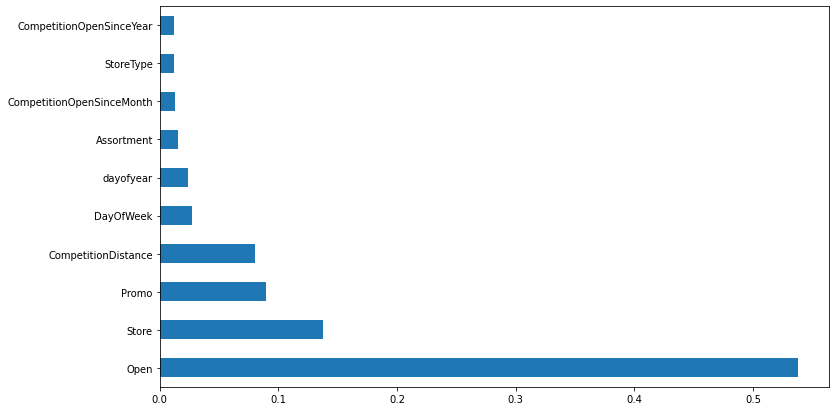

In [43]:
(pd.Series(gbrt.feature_importances_, index=X.columns)
 .nlargest(10)
   .plot(kind='barh', figsize=(12,7))) 

In [47]:
results = gbrt.predict(final_df)

In [48]:
df_results = pd.DataFrame(results, index = None)
#Remove all negative
df_results[df_results < 0] = 0
df_results["Index"]=range(0, len(df_results))
df_results.columns=["Sales","Index"]

columns_titles = ["Index","Sales"]
df_results=df_results.reindex(columns=columns_titles)
#Apply Up on the Sales column
df_results['Sales'] = df_results['Sales'].apply(np.ceil)
print(df_results.info())
print(df_results.head())
df_results.to_csv("outputm3.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305163 entries, 0 to 305162
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Index   305163 non-null  int32  
 1   Sales   305163 non-null  float64
dtypes: float64(1), int32(1)
memory usage: 3.5 MB
None
   Index   Sales
0      0   360.0
1      1  4056.0
2      2  6616.0
3      3  4410.0
4      4  7623.0
